In [1]:
import redback
import george.kernels as kernels
import george
import bilby
from bilby.core.prior import Uniform
%pylab inline

21:29 bilby INFO    : Running bilby version: 2.3.1.dev58+g0d4b91f3
21:29 redback INFO    : Running redback version: 1.0.31


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Here, I will show a general example of how you can use George and Redback to fit GPs to data

First, lets look at how we can set up a 2D GP utilising the multiwavelength information in the GP itself

21:29 redback INFO    : Metadata does not exist for this event.
21:29 redback INFO    : Setting metadata to None. This is not an error, but a warning that no metadata could be found online.
21:29 redback INFO    : Rescaling data for GP fitting.
21:29 redback INFO    : Using frequencies and time in the GP fit.
21:29 redback INFO    : Kernel used: ConstantKernel(log_constant=-5.0, ndim=2, axes=array([0, 1])) * Matern32Kernel(metric=Metric(673.6968570604146, ndim=2, axes=array([0, 1]), bounds=[(None, None)]), block=None)
21:29 redback INFO    : Ensure that the kernel is set up correctly for 2D GP.
21:29 redback INFO    : You will be returned a single GP object with frequency as a parameter
21:29 redback INFO    : Mean model not given, fitting GP with no mean model.
21:29 redback INFO    : GP final loglikelihood: 22.54222373458597
21:29 redback INFO    : GP final parameters: OrderedDict([('kernel:k1:log_constant', -1.8768780683737112), ('kernel:k2:metric:log_M_0_0', 8.769140998839164)])


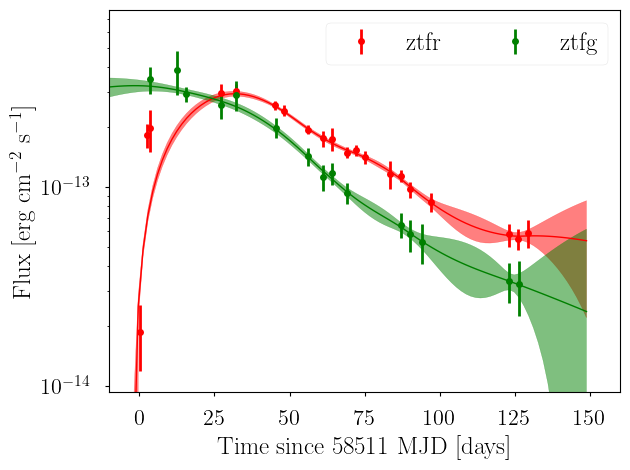

In [2]:
transient = "ZTF19aagqkrq"
ag = redback.afterglow.Afterglow.from_lasair_data(name=transient, 
    data_mode='flux', use_phase_model=True, plotting_order=['ztfr', 'ztfg'])

# Note, I could set the data mode to be any of the redback data modes
# First, lets set up a GP kernel. Note the number of dimensions as here we make the effective wavelength also a filter
k1 = kernels.ConstantKernel(-5, ndim=2)
k2 = kernels.Matern32Kernel(np.diff(ag.x).max()**2, ndim=2)
kernel = k1 * k2


# Now lets fit, note we could actually do a full blown inference here but this interface will just use scipy.optimize
out = ag.fit_gp(mean_model=None, kernel=kernel)
# The logger will print out a bunch of additional info 

# lets plot using the redback transient and analysis classes
band_colors = {'ztfr':'red', 'ztfg':'green'}
ax = ag.plot_data(show=False, band_colors=band_colors)
ax.set_xscale('linear')
ax.set_xlim(-10, 160)
ax = redback.analysis.plot_gp_lightcurves(ag, gp_output=out, axes=ax, band_colors=band_colors)

Now say I wanted to fit flux density data but also fit with a base model and assume a 1D gaussian.

21:29 redback INFO    : Metadata does not exist for this event.
21:29 redback INFO    : Setting metadata to None. This is not an error, but a warning that no metadata could be found online.
21:29 redback INFO    : Rescaling data for GP fitting.
21:29 redback INFO    : Using time in GP fit.
21:29 redback INFO    : Kernel used: ConstantKernel(log_constant=-4.9435234269199455, ndim=1, axes=array([0])) * Matern32Kernel(metric=Metric(673.6968570604146, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)
21:29 redback INFO    : Ensure that the kernel is set up correctly for 1D GP.
21:29 redback INFO    : You will be returned a GP object unique to a band/frequency in the data if working with multiband data
21:29 redback INFO    : Using inbuilt redback function bazin_sne as a mean model.
21:29 redback INFO    : Setting up GP version of mean model.
21:29 redback INFO    : Fitting for band ztfr
21:29 redback INFO    : GP final loglikelihood: 38.49350803502158
21:29 redback INFO    : GP 

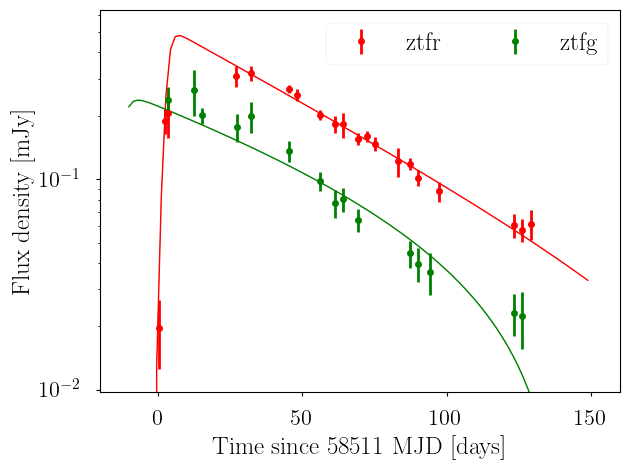

In [3]:
transient = "ZTF19aagqkrq"
ag = redback.afterglow.Afterglow.from_lasair_data(name=transient, 
    data_mode='flux_density', use_phase_model=True, plotting_order=['ztfr', 'ztfg'])

k1 = kernels.ConstantKernel(np.log(np.var(ag.y)), ndim=1)
k2 = kernels.Matern32Kernel(np.diff(ag.x).max()**2, ndim=1)
kernel = k1 * k2

# Same thing as above but now I set the data mode to flux densities


# Now I want to use the bazin supernova model as the mean model for the GP. Let's set up the prior for this
prior = redback.priors.get_priors('bazin_sne')
prior['t0'] = bilby.core.prior.Uniform(ag.x[0]-10, ag.x[0]-0.1, 't0')
prior['aa'] = bilby.core.prior.LogUniform(np.min(ag.y), np.max(ag.y), 'aa')
prior['bb'] = bilby.core.prior.LogUniform(np.min(ag.y), np.max(ag.y), 'bb')

# Lets see how we go, again this will print some diagnostic info. 
# Here we also set use_frequency=False to ensure we fit a 1D GP
out = ag.fit_gp(mean_model='bazin_sne', kernel=kernel, prior=prior, use_frequency=False)

# Plot the fit again
band_colors = {'ztfr':'red', 'ztfg':'green'}
ax = ag.plot_data(show=False, band_colors=band_colors)
ax.set_xscale('linear')
ax.set_xlim(-20, 160)
ax = redback.analysis.plot_gp_lightcurves(ag, gp_output=out, axes=ax, band_colors=band_colors)

We are not just restricted to multiwavelength data, but can also use luminosity/integrated flux. Let's try

21:29 redback WARNING : This GRB has no measured redshift, using default z = 0.75
21:29 redback INFO    : Rescaling data for GP fitting.
21:29 redback INFO    : Using time in GP fit.
21:29 redback INFO    : Kernel used: ConstantKernel(log_constant=-18.961949928128902, ndim=1, axes=array([0])) * ExpSquaredKernel(metric=Metric(619241696.1071177, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)
21:29 redback INFO    : Ensure that the kernel is set up correctly for 1D GP.
21:29 redback INFO    : You will be returned a GP object unique to a band/frequency in the data if working with multiband data
21:29 redback INFO    : Mean model not given, fitting GP with no mean model.
21:29 redback INFO    : GP final loglikelihood: 18.09543970361416
21:29 redback INFO    : GP final parameters: OrderedDict([('kernel:k1:log_constant', -4.235565449389013), ('kernel:k2:metric:log_M_0_0', 18.028964189673925)])


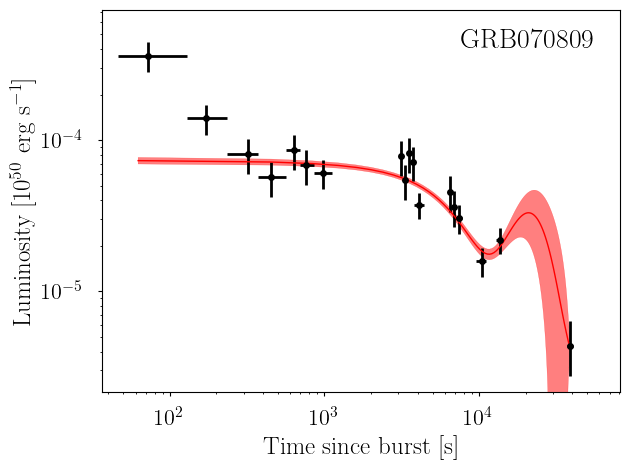

In [4]:
GRB = '070809'
ag = redback.afterglow.SGRB.from_swift_grb(name=GRB, data_mode='flux',
                                                  truncate=True, truncate_method="prompt_time_error")
ag.analytical_flux_to_luminosity()
# load GRB and convert the flux data to luminosity

# Set up kernel. Any George kernel will work.
k1 = kernels.ConstantKernel(np.log(np.var(ag.y)), ndim=1)
k2 = kernels.ExpSquaredKernel(np.diff(ag.x).max()**2, ndim=1)
kernel = k1 * k2

ax = ag.plot_data(show=False)
out = ag.fit_gp(mean_model=None, kernel=kernel, use_frequency=False)
ax = redback.analysis.plot_gp_lightcurves(ag, gp_output=out, axes=ax)

# The luminosity example above does not capture the full lightcurve. Also while optimization is nice and all. We are Bayesians, so why not get a full posterior.

In [5]:
# Let's now fit a magnetar model with a GP to the data.

model = 'full_magnetar'
magmodel = bilby.likelihood.function_to_george_mean_model(redback.model_library.all_models_dict[model])

GRB = '070809'
# Flux density, flux data
redback.get_data.get_bat_xrt_afterglow_data_from_swift(grb=GRB, data_mode="flux")
# creates a GRBDir with GRB

# create Luminosity data
# And use an analytical k-correction expression to create luminosity data if not already there.
# Can also use a numerical k-correction through CIAO
ag = redback.afterglow.SGRB.from_swift_grb(name=GRB, data_mode='flux',
                                                  truncate=True, truncate_method="prompt_time_error")
ag.analytical_flux_to_luminosity()

# Set up a simple kernel 

kernel = 2 * kernels.ExpSquaredKernel(100, ndim=1)

# use default priors for magnetar model
priors = redback.priors.get_priors(model=model)

# Fitting with a GP requires small modifications to the prior so that George understands 
mean_model = magmodel(**priors.sample())
for k, v in priors.copy().items():
    priors[f"mean:{k}"] = v
    del priors[k]

# Let's set a prior on the kernel parameters 
priors["kernel:k1:log_constant"] = Uniform(-50, 30, name="log_A", latex_label=r"$\ln A$")
priors["kernel:k2:metric:log_M_0_0"] = Uniform(-10, 10000, name="log_M_0_0", latex_label=r"$\ln M_{00}$")

# We must use a George specific likelihood available in bilby. 
# Note that GPs can only handle symmetric errors in george so we make an approximation.

likelihood = bilby.core.likelihood.GeorgeLikelihood(
    kernel=kernel, mean_model=mean_model, t=ag.x, y=ag.y, yerr=np.max(ag.y_err, axis=0))

# Standard redback/bilby things
label = 'GP'
outdir = 'testgp'

result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    outdir=outdir,
    label=label,
    sampler="nestle",
    sample="rslice",
    nlive=300,
    clean=False,
)

21:29 redback WARNING : You are downloading BAT and XRT data, you will need to truncate the data for some models.
21:29 redback WARNING : The raw data file already exists. Returning.
21:29 redback WARNING : The processed data file already exists. Returning.
21:29 redback WARNING : This GRB has no measured redshift, using default z = 0.75
21:29 bilby INFO    : Running for label 'GP', output will be saved to 'testgp'
21:29 bilby INFO    : Analysis priors:
21:29 bilby INFO    : mean:a_1=LogUniform(minimum=1e-20, maximum=1e+20, name='a_1', latex_label='$A_{1}$', unit=None, boundary=None)
21:29 bilby INFO    : mean:alpha_1=Uniform(minimum=-10, maximum=-0.5, name='alpha_1', latex_label='$\\alpha_{1}$', unit=None, boundary=None)
21:29 bilby INFO    : mean:l0=LogUniform(minimum=1e-20, maximum=100000.0, name='l0', latex_label='$L_{0}$', unit=None, boundary=None)
21:29 bilby INFO    : mean:tau=LogUniform(minimum=100.0, maximum=1000000.0, name='tau', latex_label='$\\tau$', unit=None, boundary=Non

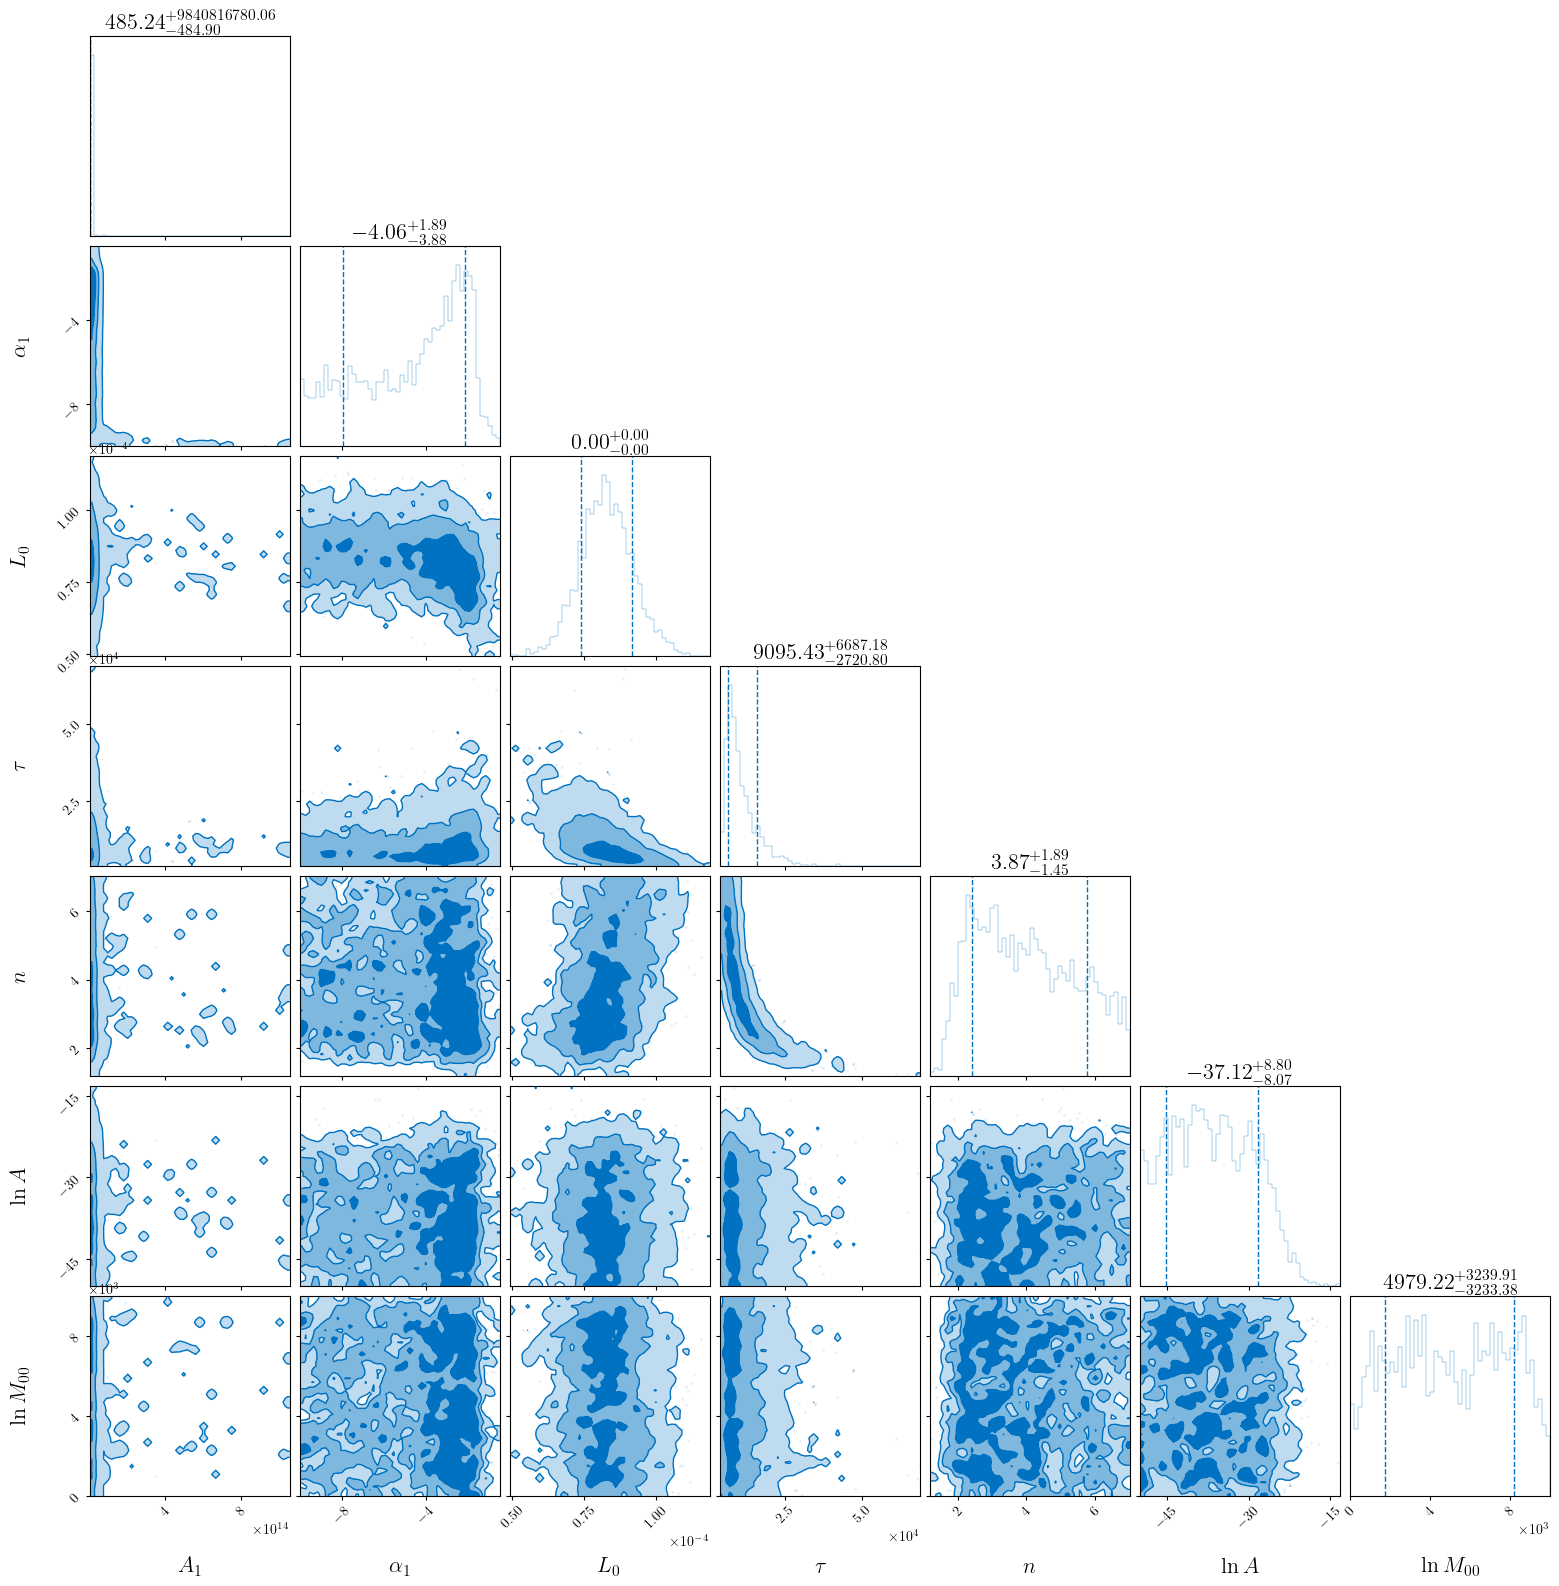

In [6]:
result.plot_corner()

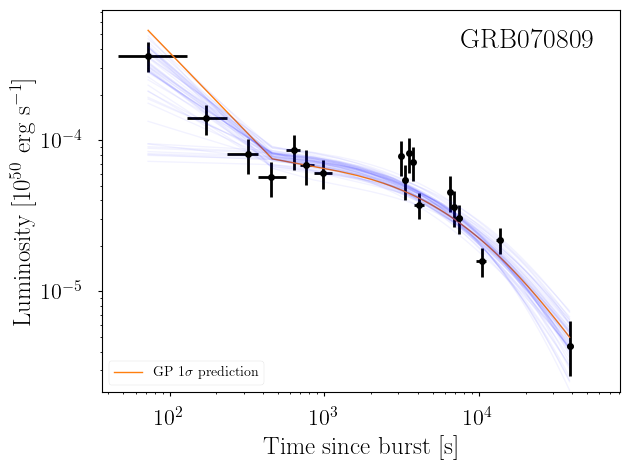

In [8]:
x = np.linspace(ag.x[0], ag.x[-1]+20, 100)
likelihood.gp.compute(ag.x, np.max(ag.y_err, axis=0))
pred_mean, pred_var = likelihood.gp.predict(ag.y, x, return_var=True)
pred_std = np.sqrt(pred_var)

# Let's plot things 
ax = ag.plot_data(show=False)

#First we plot the GP prediction
color = "#ff7f0e"
ax.plot(x, pred_mean, color=color, label=r"GP $1\sigma$ prediction")
ax.fill_between(x, pred_mean + pred_std, pred_mean - pred_std, color=color, alpha=0.3, edgecolor="none")

# Now we plot just the mean model for 50 random posterior samples 
samples = [result.posterior.iloc[np.random.randint(len(result.posterior))] for _ in range(50)]
for sample in samples:
    likelihood.set_parameters(sample)
    if not isinstance(likelihood.mean_model, (float, int)):
        trend = likelihood.mean_model.get_value(x)
    ax.loglog(x, trend, color="blue", alpha=0.05)
ax.legend()

# Voila, we now have a fit with the underlying mean model and a GP, and we have posteriors on everything.